## Прогнозирование заказов такси

### Источник данных
Исторические данные компании, предоставляющей услуги такси, о заказах такси в аэропортах.

### Основные цели проекта 

- Обучить модель для предсказания количества заказов такси на следующий час.
- Получить значение метрики RMSE на тестовой выборке должно быть не больше 48.

# 1. Подготовка

<font color=green>**Подготовим и изучим данные**</font>

- Загрузим данные, необходимые библиотеки.
- Посмотрим на данные: уникальные значения, пропуски, типы данных у столбцов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

In [2]:
#Загружаем данные.
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
#Смотрим на данные.
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
#Смотрим общую информацию.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


In [5]:
#Поменяем тип данных столбцу с датой.
data['datetime'] = pd.to_datetime(data['datetime'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


In [6]:
#Определяю количество пропущенных значений в столбцах data.
print(data.isnull().sum())

datetime      0
num_orders    0
dtype: int64


In [7]:
#Выводим списки уникальных значений для каждого столбца, чтобы найти пропуски и аномальные значения.
for column in list(data):
    print('Столбец', column, ':', data[column].unique())

Столбец datetime : ['2018-03-01T00:00:00.000000000' '2018-03-01T00:10:00.000000000'
 '2018-03-01T00:20:00.000000000' ... '2018-08-31T23:30:00.000000000'
 '2018-08-31T23:40:00.000000000' '2018-08-31T23:50:00.000000000']
Столбец num_orders : [  9  14  28  20  32  21   7   5  17  12  19  25  22   8   6   4  10  13
   2   3   0   1  11  15  16  23  18  33  24  26  30  38  34  42  31  27
  36  29  35  56  37  40  39  45  49  58  68  43  53  44  41  52  46  57
  47  64  61  50  48  55  62  54  71  78 119  99  51  60  87  90  94  82
  80  91  76  66  65  98  81  95  67]


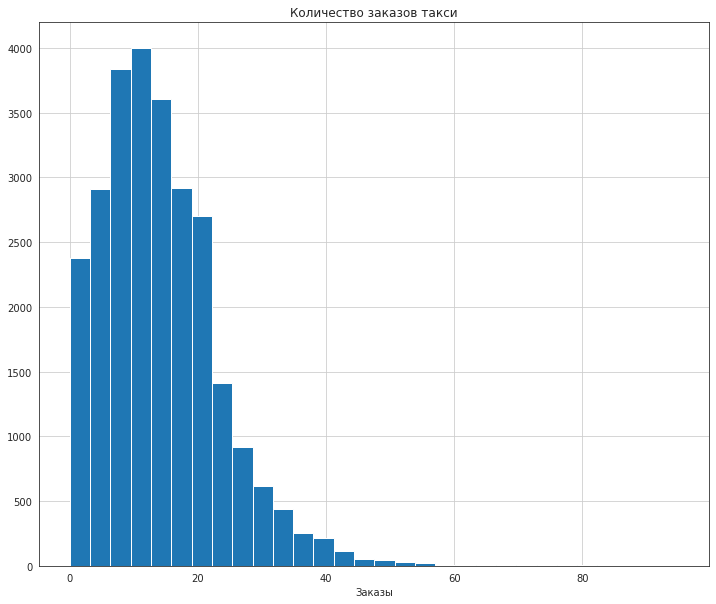

In [8]:
#Проверим данные на выбросы.
#Изучим столбец "num_orders"
#Строим гистограмму.
data['num_orders'].hist(bins=30, range = (0, 95), figsize = [12,10]) 

plt.title('Количество заказов такси', fontsize=12)
plt.xlabel('Заказы')
plt.show()

<font color=green>**Вывод**</font>

- В данных отсутствуют пропуски.
- В данных отсутствуют выбросы.
- Тип данных для столбца datetime заменили.

<font color=green>**Выполним ресемплирование.**</font>

In [9]:
#Установим индекс таблицы равным столбцу datetime.
data = data.set_index('datetime')

In [10]:
#Отсортируем индекс таблицы. 
data.sort_index(inplace=True)

In [11]:
#Выполним ресемплирование данных по одному часу.
data = data.resample('1H').sum()

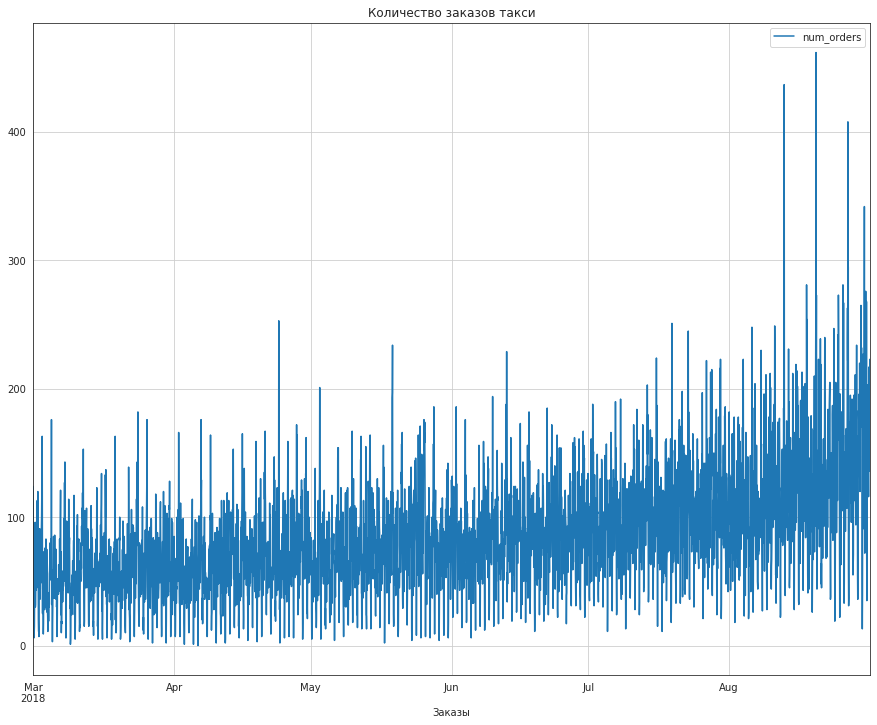

In [12]:
#Построим график полученных данных.
data.plot(grid=True, figsize=(15, 12), style='-')

plt.title('Количество заказов такси', fontsize=12)
plt.xlabel('Заказы')
plt.show()

<font color=green>**Вывод: данные подготовлены к анализу.**</font>

# 2. Анализ

In [13]:
#Чтобы во временном ряду снизить колебания, применим скользящее среднее.
#Возьмем окно в 24 часа.
data['rolling_mean'] = data.rolling(24).mean() 

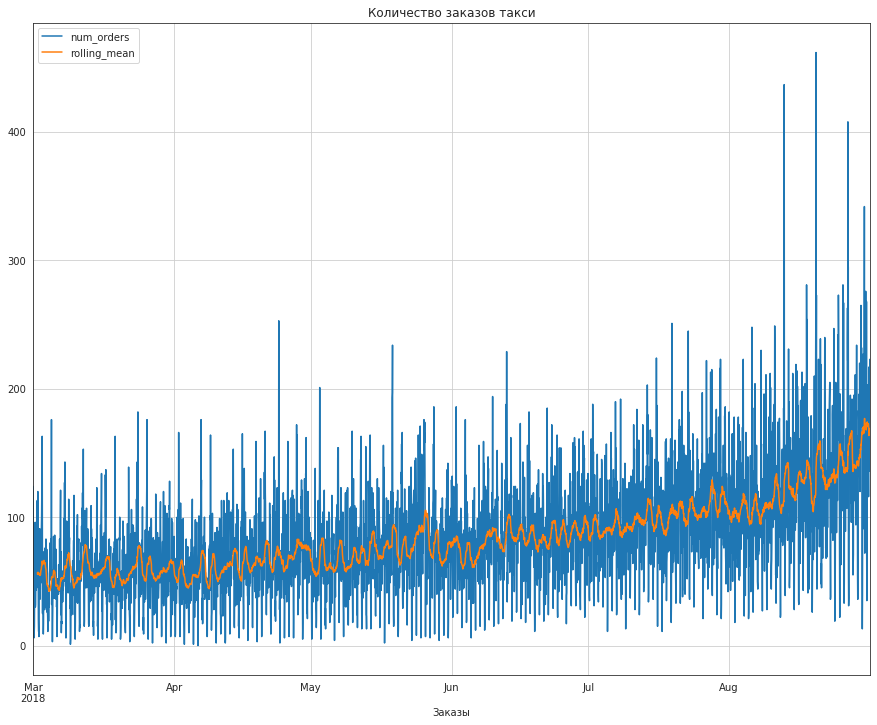

In [14]:
#Построим график полученных данных.
data.plot(grid=True, figsize=(15, 12), style='-')

plt.title('Количество заказов такси', fontsize=12)
plt.xlabel('Заказы')
plt.show()

In [15]:
#Разложим временной ряд на тренд и сезонную компоненту.
decomposed = seasonal_decompose(data.drop(['rolling_mean'], axis='columns'))

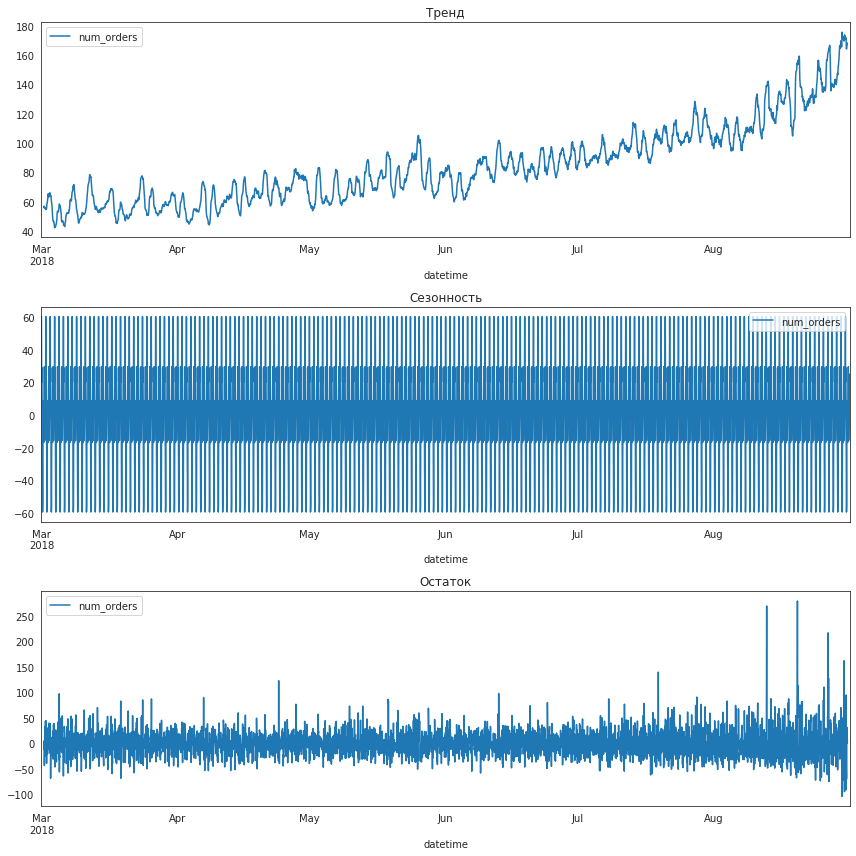

In [16]:
plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

<font color=green>**Вывод**</font>

- Видим наличие тренда: постепенное увеличение количества заказов, которое растет по экспоненте.
- Исследуем сезонность в разрезе нескольких суток, т.к. сейчас непонятно, что происходит.

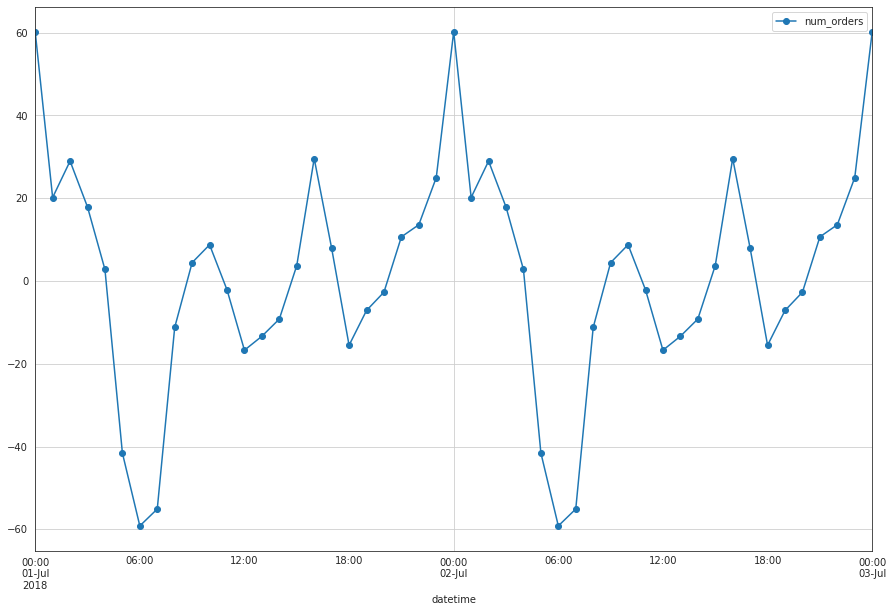

In [17]:
#Исследуем сезонность в разрезе 2 суток.
decomposed.seasonal['2018-07-01 00:00:00':'2018-07-03 00:00:00'].plot(grid=True, figsize=(15, 10), style='-o')

<font color=green>**Вывод**</font>

Видим сезооность в разрезе суток:
- В 6:00 минимум спроса, а дальше идет рост.
- Резкий рост примерно с 7:00 до 10:00.
- Снижение спроса примерно на треть с 10:00 до 12:00.
- Затем резкий рост с 12:00 до 16:00. Рост выше, чем в утренние часы.
- Снижение спроса с 16:00 до 18:00.
- Затем снова рост с 18:00 до 00:00. В точке 00:00 достигается максимальный спрос.

Можно начать работу с прогнозом.

# 3. Обучение

In [18]:
#Разобъем данные на 3 выборки: обучающую, валидационную и тестовую в соотношении: 80/10/10.
data = data.dropna()
data_train_1, data_test = train_test_split(data, test_size=0.1, random_state=12345)
data_train, data_valid = train_test_split(data_train_1, test_size=0.1, random_state=12345)

In [19]:
#Напишем функцию для создания признаков.
def make_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

In [20]:
#Вызовем функцию.
pd.options.mode.chained_assignment = None
make_features(data)
print(data.head())

                     num_orders  rolling_mean  year  month  day  dayofweek
datetime                                                                  
2018-03-01 23:00:00          58     56.833333  2018      3    1          3
2018-03-02 00:00:00          90     55.416667  2018      3    2          4
2018-03-02 01:00:00         120     56.875000  2018      3    2          4
2018-03-02 02:00:00          75     57.041667  2018      3    2          4
2018-03-02 03:00:00          64     56.958333  2018      3    2          4


In [21]:
#Для анализа зафиксируем признаки в переменных features_, а целевой признак в target_ для каждой из 3-ех выборок.
#Обучающая выборка.
features_train = data_train.drop(['num_orders'], axis=1)
target_train = data_train['num_orders']

#Валидационная выборка.
features_valid = data_valid.drop(['num_orders'], axis=1)
target_valid = data_valid['num_orders']

#Тестовая выборка.
features_test = data_test.drop(['num_orders'], axis=1)
target_test = data_test['num_orders']

<font color=green>**Обучим модель линейной регрессии.**</font>

In [22]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
#Расчитаем RMSE на валидационной выборке.
predicted_valid_lr = model_lr.predict(features_valid)
rms_valid_lr = sqrt(mean_squared_error(target_valid, predicted_valid_lr))

print("RMSE =", rms_valid_lr)

RMSE = 34.72922672754131


<font color=green>**Обучим модель градиентного бустинга LightGBM.**</font>

In [24]:
#Зададим модель, подобрав параметры с помощью grid_search.
warnings.filterwarnings("ignore", category=DeprecationWarning)
model_lgb = LGBMRegressor() 
parameters = {'max_depth': [2, 3, 4, 5], 'learning_rate': [0.1], 
              'num_leaves': [900], 'n_estimators': [50, 100, 150, 200]}
gs_lgb = GridSearchCV(model_lgb, parameters, n_jobs=-1, scoring='neg_mean_squared_error', cv=3)
gs_lgb.fit(features_train, target_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200],
                         'num_leav

In [25]:
#Выводим качество и лучшие параметры.
print('RMSE:', sqrt(-1*gs_lgb.best_score_))
print('Лучшие параметры модели:', gs_lgb.best_estimator_)

RMSE: 37.63557799701574
Лучшие параметры модели: LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=2,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=900, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [26]:
#Переобучаем модель, использовав подобранные парметры.
model_lgb_1 = LGBMRegressor(learning_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1, num_leaves=900) 
model_lgb_1.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=2,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=900, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [27]:
#Расчитаем RMSE на валидационной выборке.
predicted_valid_lgb_1 = model_lgb_1.predict(features_valid)
rms_valid_lgb_1 = sqrt(mean_squared_error(target_valid, predicted_valid_lgb_1))

print("RMSE =", rms_valid_lgb_1)

RMSE = 34.8163876369134


<font color=green>**Обучим модель градиентного бустинга CatBoost.**</font>

In [28]:
#Зададим модель, подобрав параметры с помощью grid_search.
model_cbr = CatBoostRegressor(iterations=200) 
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model_cbr.grid_search(grid, cv=3, X=features_train, y=target_train, verbose=False)

In [29]:
#Зафиксируем подобранные параметры.
parametrs = grid_search_result['params']

print('Лучшие параметры модели:', parametrs)

Лучшие параметры модели: {'depth': 6, 'l2_leaf_reg': 9, 'learning_rate': 0.1}


In [30]:
#Переобучаем модель, использовав подобранные парметры.
model_cbr_1 = CatBoostRegressor(depth = 6, l2_leaf_reg = 1, learning_rate = 0.1, iterations=200)
model_cbr_1.fit(features_train, target_train, verbose=False)

In [31]:
#Расчитаем RMSE на валидационной выборке.
predicted_valid_cbr_1 = model_cbr_1.predict(features_valid)
rms_valid_cbr_1 = sqrt(mean_squared_error(target_valid, predicted_valid_cbr_1))

print("RMSE =", rms_valid_cbr_1)

RMSE = 34.84967256584348


<font color=green>**Вывод**</font>

Все 3 модели показали значение метрики RMSE на валидационной выборке меньше 48:

- линейная регрессия: 34.72922672754131
- модель градиентного бустинга LightGBM: 34.8163876369134
- модель градиентного бустинга CatBoost: 34.84967256584348

Самая точная из них на валидационной выборке: линейная регрессия.


Теперь соединим тестовую и валидационную выборки, обучим модели на них.

In [32]:
#Разобъем данные на 2 выборки: обучающую и тестовую в соотношении: 90/10.
data_train, data_test = train_test_split(data, test_size=0.2, random_state=12345)

In [33]:
#Для анализа зафиксируем признаки в переменных features_, а целевой признак в target_ для каждой из 2-ух выборок.
#Обучающая выборка.
features_train = data_train.drop(['num_orders'], axis=1)
target_train = data_train['num_orders']

#Тестовая выборка.
features_test = data_test.drop(['num_orders'], axis=1)
target_test = data_test['num_orders']

In [34]:
#Обучим модель линейной регрессии.
model_lr_1 = LinearRegression()
model_lr_1.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
#Обучим модель градиентного бустинга LightGBM.
model_lgb_1 = LGBMRegressor(learning_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1, num_leaves=900) 
model_lgb_1.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=2,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=900, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
#Обучим модель градиентного бустинга CatBoost.
model_cbr_1 = CatBoostRegressor(depth = 6, l2_leaf_reg = 1, learning_rate = 0.1, iterations=200)
model_cbr_1.fit(features_train, target_train, verbose=False)

<font color=green>**Вывод**</font>

Проведено обучение 3 моделями. Можно провести тестирование.

# 4. Тестирование

<font color=green>**Проверим модель линейной регрессии.**</font>

In [37]:
#Рассчитаем RMSE для модели.
predictions_test_lr_1 = model_lr_1.predict(features_test)
rms_lr_1 = sqrt(mean_squared_error(target_test, predictions_test_lr_1))

print("RMSE =", rms_lr_1)

RMSE = 36.35996476865199


<font color=green>**Проверим модель градиентного бустинга LightGBM.**</font>

In [38]:
#Рассчитаем RMSE для модели.
predictions_test_lgb = model_lgb_1.predict(features_test)
rms_lgb = sqrt(mean_squared_error(target_test, predictions_test_lgb))

print("RMSE =", rms_lgb)

RMSE = 36.42261782844034


<font color=green>**Проверим модель градиентного бустинга CatBoost.**</font>

In [39]:
#Рассчитаем RMSE для модели.
predictions_test_cbr = model_cbr_1.predict(features_test)
rms_cbr = sqrt(mean_squared_error(target_test, predictions_test_cbr))

print("RMSE =", rms_cbr)

RMSE = 36.221625286433934


<font color=green>**Вывод**</font>

Все 3 модели показали значение метрики RMSE на тестовой выборке меньше 48:

- линейная регрессия: 36.35996476865199
- модель градиентного бустинга LightGBM: 36.42261782844034
- модель градиентного бустинга CatBoost: 36.221625286433934

Самая точная из них: модель градиентного бустинга CatBoost.

Для прогноза количества заказов такси на следующий час рекомендуется использовать модель градиентного бустинга CatBoost.